In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import numpy
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

# %config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
# %matplotlib inline

In [2]:
train = pd.read_csv('../normalized_train.csv',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int
            },
        parse_dates=['fecha'])
test = pd.read_csv('../normalized_test.csv',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
            },
        parse_dates=['fecha'])
train_raw = pd.read_csv('../train.csv',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
test = test.set_index('id').dropna(subset=['titulo'])
train = train.set_index('id').dropna(subset=['titulo'])
df_all = train.append(test)
train.shape

(234521, 42)

In [3]:
tipodepopiedades = [item.lower() for item in train_raw.tipodepropiedad.cat.categories]
tipodepopiedades

['apartamento',
 'bodega comercial',
 'casa',
 'casa en condominio',
 'casa uso de suelo',
 'departamento compartido',
 'duplex',
 'edificio',
 'huerta',
 'inmuebles productivos urbanos',
 'local comercial',
 'local en centro comercial',
 'lote',
 'nave industrial',
 'oficina comercial',
 'otros',
 'quinta vacacional',
 'rancho',
 'terreno',
 'terreno comercial',
 'terreno industrial',
 'villa',
 'hospedaje',
 'garage']

In [4]:
import nltk
import re
from unicodedata import normalize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
stopwords = stopwords.words('spanish')


from collections import Counter
counter = Counter()
tokenizer = RegexpTokenizer(r'\w+')
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

def countplease(x):
    
#     print(x)
    if(x!=x): return;
    
    x = tokenizer.tokenize(x)

    for word in list(x):  # iterating on a copy since removing will mess things up
        if word in stopwords or word.isnumeric() or word in tipodepopiedades:
            x.remove(word)

    x = [item.translate(trans) for item in x]
    counter.update(x)
    

df_all['titulo'].apply(lambda x: countplease(x))
counter.most_common(20)


[('venta', 132690),
 ('departamento', 47720),
 ('san', 20543),
 ('excelente', 15632),
 ('lomas', 13890),
 ('col', 13448),
 ('residencial', 12570),
 ('hermosa', 11738),
 ('condominio', 10751),
 ('valle', 9904),
 ('recamaras', 8851),
 ('oportunidad', 8725),
 ('santa', 8598),
 ('fracc', 8115),
 ('fraccionamiento', 7559),
 ('nueva', 7399),
 ('casas', 7364),
 ('remate', 7127),
 ('bonita', 6797),
 ('cerca', 6441)]

In [5]:
soloprecio = train[['logprecio', 'metros']]
solopreciotrain = soloprecio;
solotest = test[['metros']]

def buildDataframe(appearences, counter):
    newDict = dict()

    for (key, value) in dict(counter).items():
        # Check if key is even then add pair to new dictionary
    #     print(value)
        if int(value) > appearences:
            newDict[key] = value

    amountOfWords = int(len(newDict.keys()))
    words = list(newDict.keys())

    #  Add hot encoding type to dataframe with words as columns.
    for word in words: 
        soloprecio[word] = train['titulo'].str.contains(word) 
        solotest[word] = test['titulo'].str.contains(word)
        
    print('Amount of words in builingDF', amountOfWords)
    return amountOfWords  # Return the 


In [6]:
# clf = MLPRegressor(hidden_layer_sizes=(10), activation='tanh', solver='adam')

In [7]:
from sklearn.model_selection import cross_val_score
columns = []
# def rmse_cv(model, appearence):
#     columns.append(buildDataframe(appearence, counter))

    
#     every_column_except_y= [col for col in solopreciotrain.columns if col not in ['id', 'logprecio']]
#     X_train, X_test, y_train, y_test = train_test_split(solopreciotrain[every_column_except_y], solopreciotrain.logprecio, test_size=0.2, random_state=123)
#     print(solopreciotrain.logprecio.isnull().sum())
#     rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 2))
#     return(rmse)

def xgBoost_rmse(model, appearence):
    columns.append(buildDataframe(appearence, counter)) #Append to columns the amount of words for those appearences
    
    every_column_except_y= [col for col in solopreciotrain.columns if col not in ['id', 'logprecio']]
    X_train, X_test, y_train, y_test = train_test_split(solopreciotrain[every_column_except_y], solopreciotrain.logprecio, test_size=0.2, random_state=123)
    print(solopreciotrain.logprecio.isnull().sum())
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 2))
    return(rmse)

#     print(OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True)))
#     return (OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True)))
    

appearences = list(range(2000, 0, -200))
model = xgb.XGBRegressor(learning_rate =0.3, n_estimators=200, max_depth=10, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)
cv_xgboost = [xgBoost_rmse(model, appearence).mean() for appearence in appearences]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Amount of words in builingDF 94
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 107
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:40:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:43:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 120
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:48:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 151
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:51:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:54:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 179
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 212
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 266
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:15:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 353
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:27:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 464
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:43:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Amount of words in builingDF 776
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:03:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:18:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


94     0.542283
107    0.539542
120    0.532737
151    0.520929
179    0.515787
212    0.509633
266    0.502140
353    0.494287
464    0.487078
776    0.673461
dtype: float64

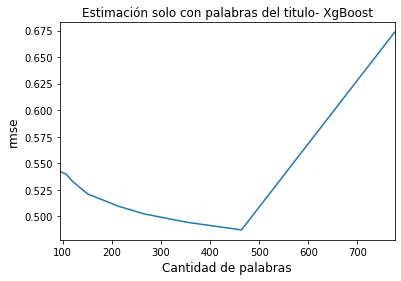

In [11]:
cv_xgboost = pd.Series(cv_xgboost, index = columns)
cv_xgboost.plot(title = "Estimación solo con palabras del titulo- XgBoost")
plt.xlabel("Cantidad de palabras", fontsize=12)
plt.ylabel("rmse", fontsize=12)
cv_xgboost

In [ ]:
model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=700, max_depth=5, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)
important_words = xgBoost_rmse(model, 800)

In [ ]:
# clffinal = MLPRegressor(activation='tanh', solver='adam')
# buildDataframe(15000)
# every_column_except_y= [col for col in solopreciotrain.columns if col not in ['id', 'logprecio']]
# X_train, X_test, y_train, y_test = train_test_split(solopreciotrain[every_column_except_y], solopreciotrain.logprecio, test_size=0.2, random_state=123)

In [ ]:
# cv_neuron = pd.Series(cv_neuron, index = columns)
# cv_neuron.plot(title = "Estimación solo con palabras del titulo")
# plt.xlabel("Columnas")
# plt.ylabel("rmse")
# cv_neuron

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(solopreciotrain[every_column_except_y], solopreciotrain.logprecio, test_size=0.2, random_state=123)
# np.sqrt(mean_squared_error(y_test, clf.predict(y_train)))

In [ ]:
clffinal = MLPRegressor(activation='tanh', solver='adam')
buildDataframe(15000)
every_column_except_y= [col for col in solopreciotrain.columns if col not in ['id', 'logprecio']]
X_train, X_test, y_train, y_test = train_test_split(solopreciotrain[every_column_except_y], solopreciotrain.logprecio, test_size=0.2, random_state=123)

In [ ]:
# clffinal.fit(X_train, y_train)

In [ ]:
# np.sqrt(mean_squared_error(y_test, clffinal.predict(X_test)))

In [ ]:
buildDataframe(50, Counter(important_words).most_common(100))

In [ ]:
from sklearn.feature_extraction import FeatureHasher

cantidad_features = 20

h = FeatureHasher(n_features=cantidad_features, input_type='string')
every_column_except_y= [col for col in solopreciotrain.columns if col not in ['id', 'logprecio', 'metros']]

train_hashtrick = solopreciotrain.copy()
test_hashtrick = solotest.copy()

# Recorro las columnas y asigno la palabra si es True, sino nan.
for el in every_column_except_y:
    train_hashtrick.loc[train_hashtrick[el] == True, el] = el
    train_hashtrick.loc[train_hashtrick[el] == False, el] = np.nan
    test_hashtrick.loc[test_hashtrick[el] == True, el] = el
    test_hashtrick.loc[test_hashtrick[el] == False, el] = np.nan

# Armo la matriz de arrays para poder usar the hashing trick
train_hashtrick = train_hashtrick[every_column_except_y].apply(lambda x: list(filter(lambda y : y == y, x)), axis=1)
test_hashtrick = test_hashtrick[every_column_except_y].apply(lambda x: list(filter(lambda y : y == y, x)), axis=1)

# Termino de armar los arrays.
names = [f'fh{el + 1}' for el in range(cantidad_features)]
f = h.transform(train_hashtrick.values)
train_hashtrick = pd.DataFrame(f.toarray(), columns=names)
train_hashtrick['id'] = train.index
train_hashtrick = train_hashtrick.set_index('id')
f = h.transform(test_hashtrick.values)
test_hashtrick = pd.DataFrame(f.toarray(), columns=names)
test_hashtrick['id'] = test.index
test_hashtrick = test_hashtrick.set_index('id')
test_hashtrick

In [ ]:
test_hashtrick.shape

In [ ]:
finaltest = pd.read_csv('../normalized_test.csv')
finaltest = finaltest.set_index('id')
finaltest = finaltest.join(test_hashtrick, how='left')

finaltest.loc[:, names] = finaltest[names].fillna(0)
finaltest.to_csv('../normalized2_test.csv')

In [ ]:
finaltrain = pd.read_csv('../normalized_train.csv')
finaltrain = finaltrain.set_index('id')
finaltrain = finaltrain.join(train_hashtrick)

finaltrain.loc[:, names] = finaltrain[names].fillna(0)
finaltrain.to_csv('../normalized2_train.csv')

In [ ]:
finaltrain.precio

In [ ]:
finaltrain.shape